<a href="https://colab.research.google.com/github/mathfather/MLCongestionControlCOSC525/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle
import warnings
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from google.colab import drive
from IPython.display import set_matplotlib_formats

drive.mount('/content/drive')
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
# config
root = os.path.join('drive', 'MyDrive', 'COSC525') # Place root folder here
figures = os.path.join(root, 'figures')
dataName = 'BD-Fifo.dat'
dataPath = os.path.join(root, dataName)
randomSeed = 233
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']

In [4]:
# load dataset
with open(dataPath, 'r') as reader:
    lines = reader.readlines()
featureNames = [feature for i, feature in enumerate(lines[3].split()) if i % 2 == 0]
data = [line.split() for line in lines[4:]]
dataset = pd.DataFrame(data=data, columns=featureNames)
dataset['feature'] = [line[:99] for line in data]
dataset['feature'] = dataset.feature.apply(lambda x: [float(i) for i in x])
labels = [line[99] for line in data]
dataset['label'] = [{'A': 0, 'C': 1}[label] for label in labels]

In [5]:
# present the dataset
dataset.head(5)

,NBREPERTE,NBREPERTEDIVCWND,DERNIERE_CWND,INTERVAL_DIV_RTT,INTERVAL_DIV_DEMI_RTT,AVANT_DERNIER_DIV_DEMI_RTT,AVANT_DERNIER_DIV_AVGLDD,AVANT_DERNIER_DIV_MINLDD,AVANT_DERNIER_DIV_MAXLDD,AVANT_DERNIER_DIV_STDLDD,AVANT_DERNIER_DIV_AVG1,AVANT_DERNIER_DIV_AVG2,AVANT_DERNIER_DIV_STD1,AVANT_DERNIER_DIV_STD2,AVGLDD_DIV_DEMI_RTT,AVGLDD_DIV_MINLDD,AVGLDD_DIV_MAXLDD,AVGLDD_DIV_STDLDD,AVGLDD_DIV_AVG1,AVGLDD_DIV_AVG2,AVGLDD_DIV_STD1,AVGLDD_DIV_STD2,MINLDD_DIV_DEMI_RTT,MINLDD_DIV_MAXLDD,MINLDD_DIV_STDLDD,MINLDD_DIV_AVG1,MINLDD_DIV_AVG2,MINLDD_DIV_STD1,MINLDD_DIV_STD2,MAXLDD_DIV_DEMI_RTT,MAXLDD_DIV_STDLDD,MAXLDD_DIV_AVG1,MAXLDD_DIV_AVG2,MAXLDD_DIV_STD1,MAXLDD_DIV_STD2,STDLDD_DIV_DEMI_RTT,STDLDD_DIV_AVG1,STDLDD_DIV_AVG2,STDLDD_DIV_STD1,STDLDD_DIV_STD2,...,AVGLDD_IP_DIV_STD1_IP,AVGLDD_IP_DIV_STD2_IP,MINLDD_IP_DIV_MAXLDD_IP,MINLDD_IP_DIV_STDLDD_IP,MINLDD_IP_DIV_AVG1_IP,MINLDD_IP_DIV_AVG2_IP,MINLDD_IP_DIV_STD1_IP,MINLDD_IP_DIV_STD2_IP,MAXLDD_IP_DIV_STDLDD_IP,MAXLDD_IP_DIV_AVG1_IP,MAXLDD_IP_DIV_AVG2_IP,MAXLDD_IP_DIV_STD1_IP,MAXLDD_IP_DIV_STD2_IP,STDLDD_IP_DIV_AVG1_IP,STDLDD_IP_DIV_AVG2_IP,STDLDD_IP_DIV_STD1_IP,STDLDD_IP_DIV_STD2_IP,AVG1_IP_DIV_AVG2_IP,AVG1_IP_DIV_STD1_IP,AVG1_IP_DIV_STD2_IP,AVG2_IP_DIV_STD1_IP,AVG2_IP_DIV_STD2_IP,STD1_IP_DIV_STD2_IP,RTT_DIV_SRTT,COND_VENO,INTERVALLE_DIV_SRTT,FCT_AVANTDERNIER_LDD,FCT_AVANTDERNIER_1,FCT_AVANTDERNIER_2,FCT_AVGLDD_1,FCT_AVGLDD_2,FCT_AVANTDERNIER_LDDIP,FCT_AVANTDERNIER_1IP,FCT_AVANTDERNIER_2IP,FCT_AVGLDD_1IP,FCT_AVGLDD_2IP,rtt_div_minrtt_,RESULTAT,feature,label
0,22.000000,3.666667,6.000000,0.006073,0.011893,1.072929,0.168142,1.110831,0.007871,0.040453,0.106823,1.061917,0.031792,45.744213,6.381069,6.606486,0.046810,0.240586,0.635312,6.315575,0.189080,272.056225,0.965880,0.007086,0.036417,0.096165,0.955966,0.028620,41.180174,136.317078,5.139565,13.572001,134.917945,4.039273,5811.864442,26.523077,2.640691,26.250849,0.785917,1130.808619,...,1.021791,0.911962,0.006172,0.012633,0.001182,0.011753,0.014357,0.012814,2.046908,0.191560,1.904279,2.326240,2.076200,0.093585,0.930320,1.136466,1.014311,9.940903,12.143668,10.838383,1.221586,1.090282,0.892513,0.000759,0.000000,0.125000,0.200133,0.265826,2.667182,0.108538,228.979194,0.886436,12.129280,1.077440,11.121876,0.178319,1.000000,A,"[22.0, 3.666667, 6.0, 0.006073, 0.011893, 1.07...",0
1,9.000000,2.250000,4.000000,0.943064,1.896876,0.998787,1.001370,1.006706,0.994454,189.802451,1.002942,1.005724,242.303524,865.032905,0.997421,1.005328,0.993093,189.542729,1.001570,1.004347,241.971962,863.849213,0.992134,0.987830,188.538146,0.996261,0.999024,240.689502,859.270784,1.004358,190.860938,1.008535,1.011332,243.654799,869.857007,0.005262,0.005284,0.005299,1.276609,4.557543,...,0.345823,8.362673,0.006452,0.020677,0.012248,0.012282,0.019006,0.459597,3.204624,1.898267,1.903532,2.945618,71.230680,0.592353,0.593995,0.919177,22.227467,1.002773,1.551740,37.524051,1.547449,37.420273,24.181912,0.117883,0.000000,0.125000,0.259721,0.710827,4.923009,0.379264,3.739317,0.355511,1.532694,36.959705,1.205917,29.057601,1.000000,A,"[9.0, 2.25, 4.0, 0.943064, 1.896876, 0.998787,...",0
2,5.000000,1.666667,3.000000,0.006431,0.008647,0.663251,0.999709,1.000000,0.998547,1717.589286,0.999825,0.997092,2066.323187,209.084981,0.663444,1.000291,0.998837,1718.089286,1.000116,0.997382,2066.924705,209.145847,0.663251,0.998547,1717.589286,0.999825,0.997092,2066.323187,209.084981,0.664216,1720.089286,1.001280,0.998544,2069.330779,209.389310,0.000386,0.000582,0.000581,1.203037,0.121732,...,0.417005,15.515577,0.006424,0.016212,0.012318,0.012284,0.012912,0.480427,2.523511,1.917374,1.912134,2.009893,74.782489,0.759804,0.757728,0.796467,29.634303,0.997267,1.048253,39.002551,1.051125,39.109431,37.207196,0.000804,0.000000,0.125000,0.500000,0.362522,0.609745,0.238996,0.548879,0.507356,1.035341,38.629004,0.631248,23.593854,1.000000,A,"[5.0, 1.666667, 3.0, 0.006431, 0.008647, 0.663...",0
3,14.000000,2.000000,7.000000,0.872087,1.731578,0.999990,1.000005,1.000013,1.000000,162917.229720,1.000004,0.995833,169136.500010,

In [7]:
def average(listLike):
    if sum(listLike) == 0 or len(listLike) == 0:
        return 0
    else:
        return sum(listLike) / len(listLike)

# Attach a text label above each bar in *rects*, displaying its height
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize='large'
        )
def plot_roc(modelName, trues, predictions, savePath=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    aucs = []
    for i, (true, prediction) in enumerate(zip(trues, predictions)):
        auc = roc_auc_score(true, prediction)
        fpr, tpr, _ = roc_curve(true, prediction)
        aucs.append(auc)
        ax.plot(fpr, tpr, label=f'ROC fold{i + 1} (auc={round(auc, 3)})', color=colors[i], alpha=0.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Ratio')
    ax.set_ylabel('True Positive Ratio')
    meanAuc = average(aucs)
    ax.set_title(f"{modelName} (Mean auc = {round(meanAuc, 3)})")
    ax.legend(loc="lower right")
    if savePath:
        plt.savefig(savePath, format='pdf')
    fig.show()
    return aucs

def plot_ranks(scores, names, savePath=None):
    length = len(scores)
    colors = ['blue'] * length
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.bar(np.arange(length), scores, color=colors, width=0.9, edgecolor='black')
    ax.set_ylabel('Feature importance')
    ax.set_xlabel('Feature Name')
    ax.yaxis.grid(True)
    ax.set_ylim([0, 0.06])
    plt.xticks(rotation=90)
    plt.setp(ax, xticks=np.arange(length), xticklabels=names)
    if savePath:
        fig.savefig(savePath, format='pdf')
    plt.tight_layout(pad=0.1)
    fig.show()

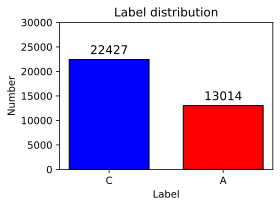

In [8]:
# plot the distribution of labels
rawLabels = dataset['RESULTAT'].tolist()
labelNames = list(set(rawLabels))
labelCounts = [rawLabels.count(name) for name in labelNames]
fig, ax = plt.subplots(1,  1, figsize=(4, 3))
rect = ax.bar(labelNames, labelCounts, width=0.7, color=colors, edgecolor='black')
ax.set_ylim([0, 30000])
ax.set_ylabel('Number')
ax.set_xlabel('Label')
ax.set_title('Label distribution')
autolabel(rect, ax)
plt.tight_layout()
fig.show()
plt.savefig(os.path.join(figures, 'labelDistribution.pdf'), format='pdf')

In [9]:
# Split the dataset into K-folds
kf = KFold(n_splits=3, random_state=randomSeed, shuffle=True)
results = {}

In [10]:
# define functions
def cvTrain(model, dataset, kfolder):
    trues = []
    predictions = []
    times = []
    print(f"Training model...")
    for i, (train_index, test_index) in enumerate(kf.split(dataset)):
        start = time.time()
        print(f"Training fold {i}...")
        trainset = dataset.iloc[train_index]
        testset = dataset.iloc[test_index]
        trainFeatures = trainset['feature'].tolist()
        trainLabels = trainset['label'].tolist()
        testFeatures = testset['feature'].tolist()
        testLabels = testset['label'].tolist()
        model.fit(trainFeatures, trainLabels)
        end = time.time()
        times.append(end - start)
        predictedLabels = model.predict(testFeatures)
        trues.append(testLabels)
        predictions.append(predictedLabels)
    print("Training done.")
    print(f"Time: {round(average(times), 3)}s / fold.")
    return trues, predictions

def report(labels, predictions):
    f1scores = []
    precisions = []
    recalls = []
    for label, prediction in zip(labels, predictions):
        f1scores.append(f1_score(label, prediction))
        precisions.append(precision_score(label, prediction))
        recalls.append(recall_score(label, prediction))
    print("-" * 26)
    print("=" * 6 + " Evaluation " + "=" * 6 )
    print("F1-score:" + (20 - len("F1-score:")) * ' ' + f"{round(average(f1scores), 3)}")
    print("Precision:" + (20 - len("Precision:")) * ' ' + f"{round(average(precisions), 3)}")
    print("Recall:" + (20 - len("Recall:")) * ' ' + f"{round(average(recalls), 3)}")
    print("-" * 26)
    return {
        "F1-score": f1scores,
        "Precision": precisions,
        "Recall": recalls
    }

def evaluateModel(modelName, model, dataset, kfolder):
    trues, predictions = cvTrain(model, dataset, kfolder)
    result = {'labels': trues, 'predictions': predictions}
    result['AUC'] = plot_roc(
        modelName,
        result['labels'],
        result['predictions'],
        savePath=os.path.join(figures, f'{modelName}.pdf')
    )
    result['report'] = report(result['labels'], result['predictions'])
    return result

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 14.393s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.474
Precision:          0.652
Recall:             0.396
--------------------------


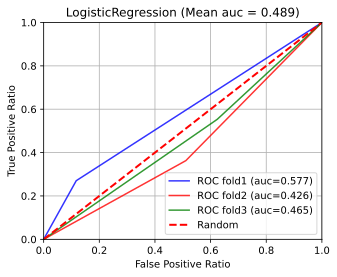

In [11]:
# LogisticRegression
lrModel = LogisticRegression(penalty='none', solver='newton-cg', max_iter=1000, random_state=randomSeed)
results['LogisticRegression'] = evaluateModel("LogisticRegression", lrModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 66.393s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.948
Precision:          0.952
Recall:             0.944
--------------------------


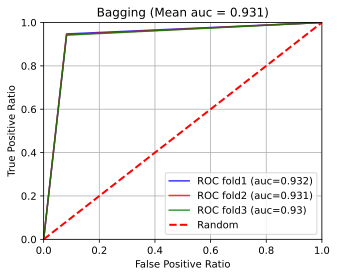

In [12]:
# Bagging
BagModel = BaggingClassifier(n_estimators=30, n_jobs=-1)
results['Bagging'] = evaluateModel("Bagging", BagModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 5.115s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.923
Precision:          0.923
Recall:             0.923
--------------------------


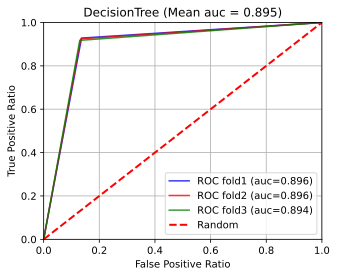

In [13]:
# DecisionTree
treeModel = DecisionTreeClassifier()
results['DecisionTree'] = evaluateModel("DecisionTree", treeModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 15.71s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.952
Precision:          0.955
Recall:             0.949
--------------------------


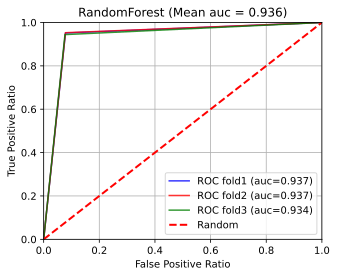

In [14]:
# RandomForest
forestModel = RandomForestClassifier(n_jobs=-1)
results['RandomForest'] = evaluateModel("RandomForest", forestModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 3.527s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.948
Precision:          0.955
Recall:             0.941
--------------------------


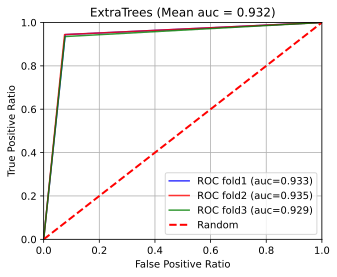

In [15]:
# ExtraTrees
extraModel = ExtraTreesClassifier()
results['ExtraTrees'] = evaluateModel("ExtraTrees", extraModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 87.942s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.946
Precision:          0.949
Recall:             0.943
--------------------------


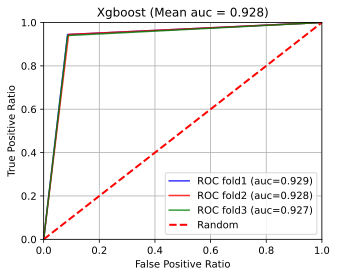

In [16]:
# Xgboost
xgbModel = GradientBoostingClassifier()
results['Xgboost'] = evaluateModel("Xgboost", xgbModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 38.674s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.859
Precision:          0.885
Recall:             0.834
--------------------------


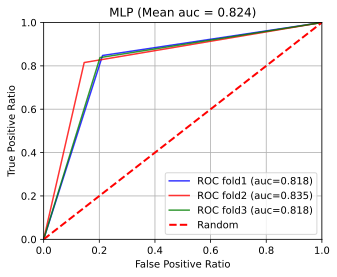

In [17]:
# MLP
mlpModel = MLPClassifier()
results['MLP'] = evaluateModel("MLP", mlpModel, dataset, kf)

Training model...
Training fold 0...
Training fold 1...
Training fold 2...
Training done.
Time: 0.633s / fold.
--------------------------
====== Evaluation ======
F1-score:           0.871
Precision:          0.887
Recall:             0.857
--------------------------


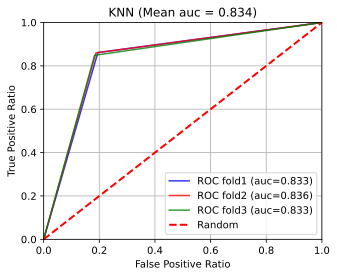

In [18]:
# KNN
knnModel = KNeighborsClassifier(n_jobs=-1)
results['KNN'] = evaluateModel("KNN", knnModel, dataset, kf)

In [19]:
extraModel = ExtraTreesClassifier()
treeModel = DecisionTreeClassifier()
features = dataset['feature'].tolist()
labels = dataset['label'].tolist()
treeModel.fit(features, labels)
extraModel.fit(features, labels)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

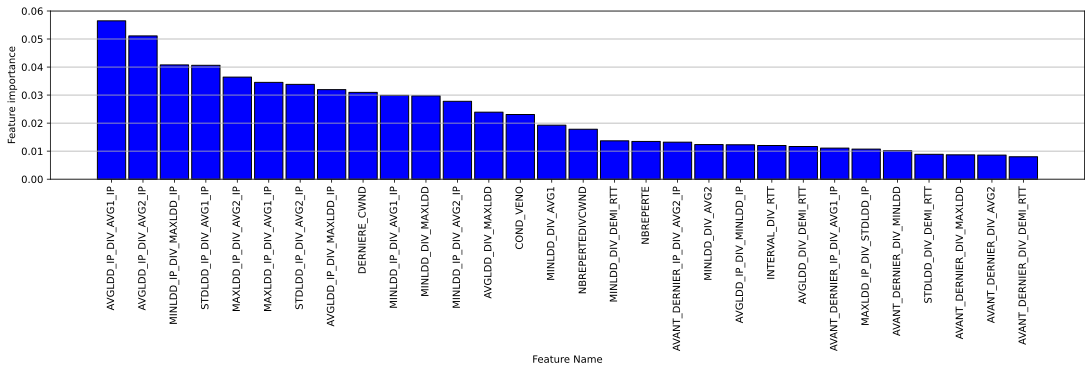

In [20]:
# Feature ranking
importances = extraModel.feature_importances_
ranks = {feature: importance  for i, (feature, importance) in enumerate(zip(featureNames, importances))}
ranks = sorted(list(ranks.items()), key=lambda x: x[1], reverse=True)
plot_ranks([item[1] for item in ranks][:30], [item[0] for item in ranks][:30], savePath=os.path.join(figures, 'featureRanks.pdf'))

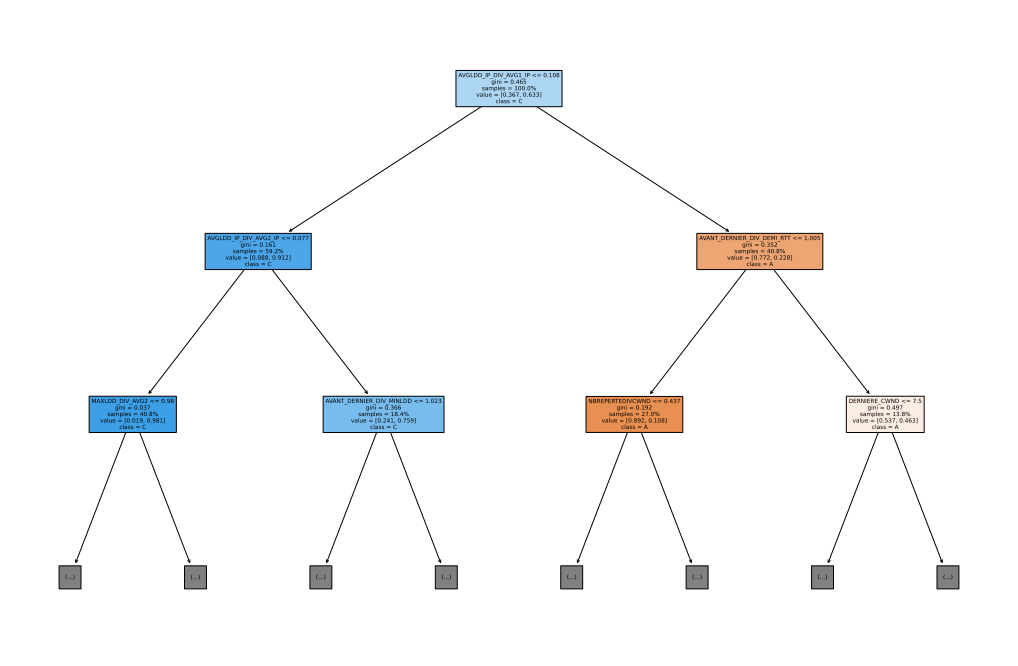

In [21]:
# Decisions
fig = plt.figure(figsize=(18,12))
tree.plot_tree(treeModel, max_depth=2, filled=True, feature_names=featureNames, class_names=['A', 'C'], proportion=True)
fig.show()
plt.savefig(os.path.join(figures, 'treeDecisions.pdf'), format='pdf')

In [ ]:
# Model comparison